In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

import warnings
import json
from tqdm import tqdm

import os
import gc

from copy import deepcopy

%load_ext tensorboard

warnings.filterwarnings('ignore')

tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tfp.__version__, tf.__version__

('0.16.0', '2.8.0')

# Util Functions

In [4]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, np.float32):
            return float(obj)
        if isinstance(obj, np.int16):
            return int(obj)
        if isinstance(obj, np.int64):
            return int(obj)
        if isinstance(obj, tf.Tensor):
            return float(obj)
        return json.JSONEncoder.default(self, obj)

In [5]:
def calculate_result(degree, bic_scores, aic_scores, A_list, B_list, losses, best_epochs, lr, optimizer, epochs, batch_size):
    # BIC Results
    best_bic_deg_idx = np.where(bic_scores == np.amin(bic_scores))[0][0]
    best_bic_deg = degrees[best_bic_deg_idx]
    bic_best_A = A_list[best_bic_deg_idx]
    bic_best_B = B_list[best_bic_deg_idx]
    best_bic = bic_scores[best_bic_deg_idx]
    
    # AIC Results
    best_aic_deg_idx = np.where(aic_scores == np.amin(aic_scores))[0][0]
    best_aic_deg = degrees[best_aic_deg_idx]
    aic_best_A = A_list[best_aic_deg_idx]
    aic_best_B = B_list[best_aic_deg_idx]
    best_aic = aic_scores[best_aic_deg_idx]
    
    last_losses = [loss[-1] for loss in losses]
    
    result = {'degree': degree,
          'losses': last_losses,
          'A_list': A_list,
          'B_list': B_list,
              
          'bic_scores': bic_scores,
          'best_bic': best_bic,
          'best_bic_A': bic_best_A,
          'best_bic_B': bic_best_B,
          'best_bic_deg': best_bic_deg,
          'best_bic_deg_idx': best_bic_deg_idx,
            
          'aic_scores': aic_scores,
          'best_aic': best_aic,
          'best_aic_A': aic_best_A,
          'best_aic_B': aic_best_B,
          'best_aic_deg': best_aic_deg,
          'best_aic_deg_idx': best_aic_deg_idx,
              
          'lr': lr,
          'optimizer': optimizer,
          'epochs': epochs,
          'best_epochs': best_epochs,
          'batch_size': batch_size
        }
    
    return result

In [6]:
def save_result(folder_dir, file_name, result):  
    with open(folder_dir + '/' + file_name + '.json', "w") as write_file:
        json.dump(result, write_file, cls=NumpyEncoder)

In [7]:
def nll(dist, samples):
    """Calculates the negative log-likelihood for a given distribution
    and a data set."""
    ll = dist.log_prob(samples)
    mask_ll = tf.boolean_mask(ll, tf.math.is_finite(ll))
    ll = tf.where(tf.math.is_finite(ll), ll, [-1000])
    if mask_ll.shape[0] / ll.shape[0] < 0.7:
        print('Too much nan in one batch', mask_ll.shape[0], ll.shape[0] )
    return -tf.reduce_mean(ll)

In [8]:
#@tf.function
def get_loss_and_grads(dist, samples):
    with tf.GradientTape() as tape:
        tape.watch(dist.trainable_variables)
        loss = nll(dist, samples)
    grads = tape.gradient(loss, dist.trainable_variables)

    return loss, grads

In [9]:
def fit_distribution(dist, samples, opti, epoch):
    loss, grads = get_loss_and_grads(dist, samples)

    if tf.math.is_finite(loss) and tf.math.is_finite(grads[1]):
        opti.apply_gradients(zip(grads, dist.trainable_variables))

    return loss

In [10]:
#Expands a vector to a polynomial design matrix: from a constant to the deg-power
def polyBasisScale(x_last, deg):
    #Expands a vector to a polynomial design matrix: from a constant to the deg-power
    return np.diag(np.squeeze((np.column_stack([x_last**deg for deg in range(0, deg+1)]))))

In [11]:
def polynomial_basis_function(x, power):
    return x ** power

In [12]:
def expand(x, bf, bf_args=None):
    if bf_args is None:
        return np.concatenate([np.ones(x.shape), bf(x)], axis=1)
    else:
        return np.array([np.ones(x.shape)] + [bf(x, bf_arg) for bf_arg in bf_args]).T

In [13]:
def plot_losses(losses, degrees, y_lim = (-50,50)):
    fig, ax = plt.subplots()
    for i,loss in enumerate(losses):
        ax.plot(range(len(loss)), loss, label = str(degrees[i]))
    
    ax.set_ylim(y_lim)
    ax.legend()

    plt.show()
    return fig, ax

In [14]:
def generate_file_list_dataset(path_list, outlier_list):
    path_list_without_outlier = []

    for root, dirs, files in os.walk(os.path.abspath(path_list)):
        files.sort()
        for idx, file in enumerate(tqdm(files)):
            if idx in outlier_list:
                continue
            else:
                path_list_without_outlier.append(os.path.join(root, file))

    file_list_dataset = tf.data.Dataset.from_tensor_slices(path_list_without_outlier)
    
    return file_list_dataset

In [15]:
def generate_start_indicies_dataset(start_indicies_file, outlier_list):
    start_indicies_without_outlier = []

    with open(start_indicies_file, "r") as read_file:
        start_indicies_all = np.array((json.load(read_file)))
    
    for idx, start_index in enumerate(tqdm(start_indicies_all)):
        if idx in outlier_list:
            continue
        else:
            start_indicies_without_outlier.append(start_index)

    start_indicies_dataset = tf.data.Dataset.from_tensor_slices(start_indicies_without_outlier)
    
    return start_indicies_dataset

# Load Data

In [16]:
class DataProcessor(object):
    def __init__(self, batch_size, dataset, num_points_in_one_traj):
        self.batch_size = batch_size
        self.dataset = dataset  
        self.num_points_in_one_traj = num_points_in_one_traj
        self.loaded_dataset = None
    
    def _extract_ego_trajs(self, file_path, start_idx):
        file_str = str(file_path.numpy())[2:-1]
        ego_trajs_all = []
        times_all = []
        with open(file_str, "r") as read_file:
            traj_data = json.load(read_file)
            
        ego_traj_temp = np.array(traj_data['ego_traj'])[start_idx : start_idx+self.num_points_in_one_traj]
        ego_traj_temp = ego_traj_temp[:, :2] - ego_traj_temp[0,:2] # let trajectories start from zero
        ego_traj = np.concatenate((ego_traj_temp[:, 0], ego_traj_temp[:, 1]), axis = 0)

        times = np.array(traj_data['timestamp'])[start_idx: start_idx+self.num_points_in_one_traj]
        times = times - times[0]
        
        return tf.convert_to_tensor(times, dtype=tf.float32), tf.convert_to_tensor(ego_traj, dtype=tf.float32)
    
    
    def _load_data(self, file_path, start_idx):
        return tf.py_function(self._extract_ego_trajs, [file_path, start_idx], [tf.float32, tf.float32])
    
    def load_process(self, shuffle = False):
        self.loaded_dataset = self.dataset.map(map_func = self._load_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)

        self.loaded_dataset = self.loaded_dataset.cache()

        # Shuffle data and create batches
        if shuffle:
            self.loaded_dataset = self.loaded_dataset.shuffle(buffer_size=self.loaded_dataset.__len__())
        
        # Set batch size for dataset
        self.loaded_dataset = self.loaded_dataset.batch(self.batch_size)

        # Make dataset fetch batches in the background during the training of the model.
        self.loaded_dataset = self.loaded_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        
    def get_batch(self):
        return next(iter(self.loaded_dataset))

In [30]:
BATCH_SIZE = 1024
EPOCHS = 100
lr = 5e-3

original_num_points_in_one_traj = 91
num_points_in_one_traj = 91

In [19]:
with open("data/ego_trajs_not_moving_indicies.json", "r") as read_file:
    idx_not_moving = set(json.load(read_file))
    
with open("data/ego_trajs_" + str(num_points_in_one_traj) + "_json/ego_trajs_outlier_indicies.json", "r") as read_file:
    idx_outlier = set(json.load(read_file))

idx_invalid_idx = idx_outlier | idx_not_moving
    
list_dataset = generate_file_list_dataset('data/ego_trajs_json/', idx_invalid_idx)
start_idx_dataset = generate_start_indicies_dataset("data/ego_trajs_" + str(num_points_in_one_traj) + "_json/ego_trajs_start_point_indicies.json", idx_invalid_idx)
combined_dataset = tf.data.Dataset.zip((list_dataset, start_idx_dataset))

dataProcessor = DataProcessor(BATCH_SIZE, combined_dataset, num_points_in_one_traj)
dataProcessor.load_process(shuffle = True)

print(dataProcessor.loaded_dataset.__len__())

100%|██████████| 487002/487002 [00:00<00:00, 3084599.97it/s]


tf.Tensor(377, shape=(), dtype=int64)


In [19]:
len(idx_invalid_idx), len(idx_not_moving), len(idx_outlier)

(101103, 101096, 7)

# Analyse ego_xy with observation noise

## Training

In [31]:
def build_mvn(alpha, beta_diag, beta_by_diag, phi_t, num_points):
    def mvn_from_alpha_beta(alpha, beta_diag, beta_by_diag, phi_t):      
        b_by_diag = tf.eye(num_points_in_one_traj, dtype = tf.float64) * tf.math.softplus(beta_diag) * tf.math.tanh(beta_by_diag)
        by_eye = tf.convert_to_tensor([[0,1],[1,0]], dtype=tf.float64)
        b_diag = tf.eye(2*num_points, dtype=tf.float64) * tf.math.softplus(beta_diag)
        b_kron = b_diag  + tf.experimental.numpy.kron(by_eye, b_by_diag)

        cov =   b_kron + (phi_t @ alpha )  @ (tf.transpose(phi_t @ alpha, perm=[0, 2, 1]))
        
        return tfd.MultivariateNormalTriL(loc=tf.zeros((2* num_points), dtype = tf.float64), scale_tril=tf.linalg.cholesky(cov))
    
    return tfp.experimental.util.DeferredModule(build_fn=mvn_from_alpha_beta, alpha=alpha, beta_diag=beta_diag, beta_by_diag=beta_by_diag, phi_t = phi_t)

In [32]:
def train(alpha, beta_diag, beta_by_diag, opti, data_loader, epochs = 100, tf_summary_writer = None, verbose = False, early_stop = True):
    model_losses = []
    best_alpha = None
    best_beta_diag, best_beta_by_diag = None, None
    best_epoch_loss = np.inf
    best_epoch = 0
    for epoch in tqdm(range(epochs)):
        batch_losses = []
        for timestamp_samples, trajectories_samples in data_loader:

            phi_t_batch = expand(timestamp_samples/t_scale_factor, bf=polynomial_basis_function, bf_args=range(1, deg+1)).transpose((1, 0, 2))
            phi_t_kron = np.kron(np.eye(2), phi_t_batch[:, :, 1:])
            
            phi_t_kron = tf.cast(phi_t_kron, dtype = tf.float64)
            trajectories_samples = tf.cast(trajectories_samples, dtype = tf.float64)
            
            mvn_test = build_mvn(alpha=alpha, beta_diag=beta_diag, beta_by_diag=beta_by_diag, phi_t = phi_t_kron, num_points = num_points_in_one_traj)

            batch_loss = fit_distribution(mvn_test, trajectories_samples, optimizer,epoch)
            batch_losses.append(batch_loss)
            
            tf.keras.backend.clear_session() # clear the initiated model in this loop
        gc.collect()
            
        assert not tf.math.is_nan(np.mean(batch_losses))
        
        epoch_loss = np.mean(batch_losses)
        
        if epoch_loss < best_epoch_loss:
            best_epoch_loss = epoch_loss
            best_epoch = epoch
            best_alpha, best_beta_diag, best_beta_by_diag = deepcopy(alpha), deepcopy(beta_diag), deepcopy(beta_by_diag)
        
        model_losses.append(epoch_loss)
        
        if tf_summary_writer:
            with tf_summary_writer.as_default():
                tf.summary.scalar('loss', np.mean(batch_losses), step=epoch)
        
        # Early stop if epoch loss doesn't decrease for more then 20 epochs 
        if early_stop and epoch - best_epoch >=20:
            print('Early Stop at ' + str(epoch) + '(' + str(best_epoch) + ')' + ' epoch')
            break
        
        if(epoch %10 == 0 and verbose):
        #    A_scale_mat = polyBasisScale(t_scale_factor, deg)
        #    A_scale_mat = A_scale_mat[1:, 1:]
        #    A_est = np.linalg.inv(np.kron(np.eye(2), A_scale_mat)) @ A.numpy()
        #    A_est = A_est @ A_est.T
            print('Epoch ', epoch, ', Loss: ', model_losses[-1])
        #    print(tf.math.softplus(B_diag), tf.math.softplus(B_diag) * tf.math.tanh(B_by_diag))
        #    print(np.diag(A_est))
        #    #print('Rank: ', np.linalg.matrix_rank(mvn_test.covariance()))
        
    return model_losses, best_epoch_loss, best_epoch, best_alpha, best_beta_diag, best_beta_by_diag

In [33]:
def compute_AIC_BIC(nll, deg, num_points):
    # Compute bayesian information criterion
    degree_of_freedom = 2 + (2*deg)*(2*(deg)+1) / 2
    bic_score = nll + 0.5 * np.log(num_points) * degree_of_freedom
    
    # Compute Akaike information criterion
    aic_score = nll + degree_of_freedom
    
    return aic_score, bic_score

In [35]:
losses = []
best_epoch_losses = []
best_epochs = []
bic_scores = []
aic_scores = []
A_list, B_list = [], []
lr_schedules_ser = []
optimizers_ser = []
log_root_dir = 'logs/gradient_tape/ego_xy' + str(num_points_in_one_traj) + '_678'
t_scale_factor = (num_points_in_one_traj-1) / 10 # The time duration of one trajectory
nan_batches = []
degrees = np.linspace(1, 8, 8, dtype=np.int16) # analyse polynomials from degree 1 to 8
degrees = [6,7,8]
for i_d, deg in enumerate(degrees):
    print('Trainig deg ',deg)
    
    if deg <= 3:
        boundaries = [dataProcessor.loaded_dataset.__len__().numpy()*30, dataProcessor.loaded_dataset.__len__().numpy()*70]
        values = [4e-3, 5e-4, 1e-4]
    #elif deg == 5:
    #    boundaries = [dataProcessor.loaded_dataset.__len__().numpy()*15, dataProcessor.loaded_dataset.__len__().numpy()*70]
    #    values = [1e-3, 1e-4, 5e-5]
    else:
        boundaries = [dataProcessor.loaded_dataset.__len__().numpy()*15, dataProcessor.loaded_dataset.__len__().numpy()*70]
        values = [1e-3, 1e-4, 5e-5]
    
    #oundaries = [dataProcessor.loaded_dataset.__len__().numpy()*20, dataProcessor.loaded_dataset.__len__().numpy()*70]
    #values = [1e-3, 1e-3, 1e-3]

    lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)   
    
    lr_schedules_ser.append(tf.keras.optimizers.schedules.serialize(lr_schedule))
    optimizers_ser.append(tf.keras.optimizers.serialize(optimizer))
    
    A = tf.Variable(np.random.randn(2*(deg), 2*(deg)) * 1e-1 , dtype=tf.float64, name='alpha') # Model uncertainty
    B_diag = tf.Variable(-10 + np.random.randn(1) * 1e-1, dtype=tf.float64, name='beta_diag') # Log of Observation uncertainty
    B_by_diag =  tf.Variable(-1 + np.random.randn(1) * 1e-1, dtype=tf.float64, name='beta_by_diag')

    
    train_log_dir = log_root_dir + '/deg_' + str(deg)
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)  
   
    model_losses, best_epoch_loss, best_epoch, best_alpha, best_beta_diag, best_beta_by_diag = train(alpha=A, beta_diag=B_diag, beta_by_diag=B_by_diag, opti=optimizer, 
                                                     epochs = EPOCHS, data_loader=dataProcessor.loaded_dataset, tf_summary_writer = train_summary_writer, verbose = False, early_stop=False)
            
    # Add model loss
    losses.append(model_losses)
    best_epoch_losses.append([best_epoch_loss])
    
    # store the best epoch
    best_epochs.append(best_epoch)
    
    # Compute the AIC and BIC score
    aic_score, bic_score = compute_AIC_BIC(nll = best_epoch_loss, deg = deg, num_points = num_points_in_one_traj)

    bic_scores.append(bic_score)
    aic_scores.append(aic_score)
    
    # Compute the model uncertainty, A_unscaled = np.linalg.inv(scale_mat) @ A_scaled
    A_scale_mat = polyBasisScale(t_scale_factor, deg)
    A_scale_mat = A_scale_mat[1:, 1:]
    A_est = np.linalg.inv(np.kron(np.eye(2), A_scale_mat)) @ best_alpha.numpy()
    A_est = A_est @ A_est.T
    A_list.append(A_est)
    
    # Compute the observation uncertainty, B_cov = tf.eye(num_points_in_one_traj) * tf.math.softplus(B)
    B_est = {'B_diag': (tf.math.softplus(best_beta_diag)).numpy(), 
             'B_by_diag': (tf.math.softplus(best_beta_diag) * tf.math.tanh(best_beta_by_diag)).numpy()}
    B_list.append(B_est)
    print(deg, model_losses[-1], bic_score, aic_score)

Trainig deg  6


  0%|          | 0/100 [01:37<?, ?it/s]


ResourceExhaustedError: failed to allocate memory [Op:AddV2]

In [24]:
result = calculate_result(degrees, bic_scores, aic_scores, A_list, B_list, best_epoch_losses, best_epochs, lr_schedules_ser, optimizers_ser, EPOCHS, BATCH_SIZE)

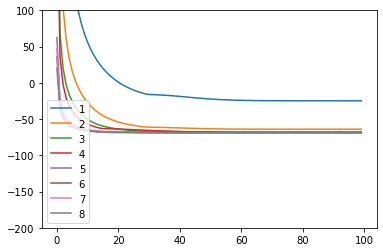

In [25]:
fig,ax = plot_losses(losses, degrees = degrees, y_lim=[-200, 100])
fig.savefig('imgs/ego_' + str(num_points_in_one_traj) + '.svg')

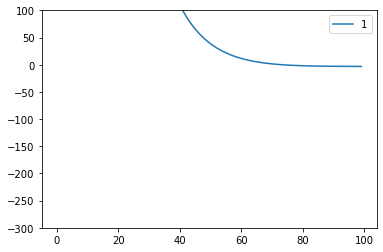

In [53]:
fig,ax = plot_losses([model_losses], degrees = degrees, y_lim=[-300, 100])

In [51]:
best_epochs

[99, 99, 99, 95, 55, 64, 41, 55]

In [48]:
result['best_aic_A']

array([[ 8.02943682e+00,  2.71549135e-03, -9.56875811e-03,
         8.82074500e-01,  6.80324209e-03, -1.94478557e-03],
       [ 2.71549135e-03,  1.63642511e-01, -1.30008399e-02,
        -1.19377636e-02, -7.27166965e-04,  1.68067105e-03],
       [-9.56875811e-03, -1.30008399e-02,  4.55961747e-03,
        -1.56248670e-03, -1.44848073e-03, -3.31181957e-05],
       [ 8.82074500e-01, -1.19377636e-02, -1.56248670e-03,
         9.28956066e+00, -9.92817541e-03, -1.19916803e-02],
       [ 6.80324209e-03, -7.27166965e-04, -1.44848073e-03,
        -9.92817541e-03,  1.81727178e-01, -1.41761826e-02],
       [-1.94478557e-03,  1.68067105e-03, -3.31181957e-05,
        -1.19916803e-02, -1.41761826e-02,  4.92513140e-03]])

In [49]:
result['best_aic_B']

{'B_diag': array([3.3832584e-05], dtype=float32),
 'B_by_diag': array([-3.235142e-07], dtype=float32)}

In [55]:
save_result(folder_dir =log_root_dir, file_name='result_summary', result=result)
with open(log_root_dir + '/' + 'lr_schedules' + '.json', "w") as write_file:
    json.dump(lr_schedules_ser, write_file, cls=NumpyEncoder)
with open(log_root_dir + '/' + 'optimizers' + '.json', "w") as write_file:
    json.dump(optimizers_ser, write_file, cls=NumpyEncoder)

# Dummy Code

In [33]:
num_points_in_one_traj = 21
deg_to_change = 1
idx_to_change = deg_to_change-1
with open('logs/gradient_tape/ego_xy' + str(num_points_in_one_traj) + '/result_summary.json', "r") as read_file:
    result_old = json.load(read_file)
          
with open('logs/gradient_tape/ego_xy' + str(num_points_in_one_traj) + '_only_' + str(deg_to_change) + 'th/result_summary.json', "r") as read_file:
    result_sub = json.load(read_file)

In [34]:
result_old['losses'][idx_to_change] = result_sub['losses'][0]
result_old['A_list'][idx_to_change] = result_sub['A_list'][0]
result_old['B_list'][idx_to_change] = result_sub['B_list'][0]

result_old['lr'][idx_to_change] = result_sub['lr'][0]
result_old['optimizer'][idx_to_change] = result_sub['optimizer'][0]

result_old['bic_scores'][idx_to_change] = result_sub['bic_scores'][0]
best_bic_deg_idx = np.where(result_old['bic_scores'] == np.amin(result_old['bic_scores']))[0][0]
result_old['best_bic'] = result_old['bic_scores'][best_bic_deg_idx]
result_old['best_bic_A'] = result_old['A_list'][best_bic_deg_idx]
result_old['best_bic_B'] = result_old['B_list'][best_bic_deg_idx]
result_old['best_bic_deg'] = result_old['degree'][best_bic_deg_idx]
result_old['best_bic_deg_idx'] = best_bic_deg_idx


result_old['aic_scores'][idx_to_change] = result_sub['aic_scores'][0]
best_aic_deg_idx = np.where(result_old['aic_scores'] == np.amin(result_old['aic_scores']))[0][0]
result_old['best_aic'] = result_old['aic_scores'][best_aic_deg_idx]
result_old['best_aic_A'] = result_old['A_list'][best_aic_deg_idx]
result_old['best_aic_B'] = result_old['B_list'][best_aic_deg_idx]
result_old['best_aic_deg'] = result_old['degree'][best_aic_deg_idx]
result_old['best_aic_deg_idx'] = best_aic_deg_idx

with open('logs/gradient_tape/ego_xy' + str(num_points_in_one_traj) + '/result_summary_new.json', "w") as write_file:
    json.dump(result_old, write_file, cls=NumpyEncoder)